#  SVM Classifier for  SER (Speech Emotion Recognition)

Support Vector Machines (SVM) with non-linear kernels are often the most successfully applied algorithms for speech emotion recognition. 

A SVM using non-linear kernel transforms the input feature vectors into a higher dimensional feature space using a kernel mapping function. By choosing appropriate non-linear kernels functions, classifiers that are non-linear in the original space can become linear in the feature space.

## Dataset

The Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS),and it is free to download. This dataset has 7356 files rated by 247 individuals 10 times on emotional validity, intensity, and genuineness. here the Speech files of all actors (01-24) will be used and the files are available under path ../datasets/RAVDESS. It contains 1440 files: 60 trials per actor x 24 actors = 1440. 
Filename identifiers:
<ol>
<li>Modality (01 = full-AV, 02 = video-only, 03 = audio-only).</li>
<li>Vocal channel (01 = speech, 02 = song).</li>
<li>Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).</li>
<li>Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.</li>
<li>Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").</li>
<li>Repetition (01 = 1st repetition, 02 = 2nd repetition)..</li>
<li>Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).</li>
</ol>

## Downloading Libraries

In [1]:
#!pip install librosa soundfile numpy sklearn pyaudio

In [2]:
#!pip install soundfile

In [3]:
# pip install seaborn

## Libraries Import

In [4]:
# Import our libraries

import os,glob
import librosa
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import time
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sn
from sklearn.svm import SVC
import seaborn as sn
from sklearn.model_selection import cross_val_score
import librosa.display
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import soundfile
import os.path

## Feature Extraction

This function loads the file give the file path and after resampling and computing MFCC features, returns the features. We have selected the no. of MFCCs as 40.


In [5]:
#Extract features (mfcc, chroma, mel) from a given sound file(with path)
def extract_feature(file_name, mfcc):
    X, sample_rate = librosa.load(os.path.join(file_name), res_type='kaiser_fast')
    result=np.array([])
    if mfcc:
        mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
        result=np.hstack((result, mfccs))
    return result

In [6]:
#Emotions in the RAVDESS dataset, it will not take the neutral into the modeling process
emotions={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fear',
  '07':'disgust',
  '08':'surprise'
}
#Emotions to observe(all emotions except neutral)
observed_emotions=['neutral','calm', 'happy', 'sad','angry','fear', 'disgust','surprise']

## Retrieve RAVDESS dataset from File System

In [7]:
#audio file path in file system
RAV = "../datasets/RAVDESS/"
CSV = "../datasets/CSV/"
# test to run one example 
dir_list = os.listdir(RAV+"Actor_01/")
dir_list[0:5]

['03-01-01-01-01-01-01.wav',
 '03-01-01-01-01-02-01.wav',
 '03-01-01-01-02-01-01.wav',
 '03-01-01-01-02-02-01.wav',
 '03-01-02-01-01-01-01.wav']

In [8]:
#Load the data and extract features for each sound file
def load_data(test_size=0.2): 
    x,y=[],[]
    
    # feature to extract
    mfcc = True 
    path= RAV+"Actor_*/*.wav"   
    for file in glob.glob(path):
        file_name=os.path.basename(file)
        emotion=emotions[file_name.split("-")[2]] #to get emotion according to filename. dictionary emotions is defined above.
        if emotion not in observed_emotions: #options observed_emotions - RAVDESS and TESS, ravdess_emotions for RAVDESS only
            continue
        feature=extract_feature(file, mfcc)
        x.append(feature)
        y.append(emotion)
    return {"X":x,"y":y}

In [9]:
#load data into memory
Trial_dict = load_data(test_size = 0.3)

In [10]:
X = pd.DataFrame(Trial_dict["X"])
y = pd.DataFrame(Trial_dict["y"])
X.shape, y.shape

((1440, 40), (1440, 1))

In [11]:
#renaming the label column to emotion, store the attributes and label into dataframe
y=y.rename(columns= {0: 'emotion'})
data = pd.concat([X, y], axis =1)
#view the first 10 record
data.head(10)

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,emotion
0,-707.226318,68.469788,-11.611320,22.716902,-0.303072,5.822211,-6.081500,-2.655389,-9.960321,-5.103168,...,-2.744597,-2.285304,-2.167415,-2.929328,-1.793007,-0.758816,-2.190662,-2.976669,-2.087532,neutral
1,-703.383240,70.197769,-15.213277,27.412649,-0.247905,5.837488,-4.831208,-4.569034,-10.607910,-3.820005,...,-3.116829,-1.922442,-2.564388,-2.969680,-0.872745,-1.239757,-3.162743,-2.940819,-2.609301,neutral
2,-700.794006,70.959595,-11.694939,23.595743,-2.463483,6.388802,-5.021149,-4.631995,-9.482592,-5.633955,...,-2.547276,-2.147709,-1.945596,-2.771029,-1.836579,-1.192164,-2.677400,-3.442389,-2.399600,neutral
3,-694.826050,69.669205,-9.815083,23.888597,-1.381263,8.620013,-4.805181,-6.055672,-9.544140,-5.380029,...,-2.928294,-2.366574,-3.042785,-3.062823,-1.447675,-0.979923,-2.325146,-3.415248,-3.387120,neutral
4,-737.437988,77.273209,-11.190391,26.755884,-1.537418,8.085284,-7.015995,-3.006230,-8.947398,-7.313802,...,-2.158252,-1.256279,-2.996467,-1.348934,-0.796627,-1.648554,-1.981015,-3.455514,-3.098281,calm
5,-716.575806,79.555000,-9.764153,21.266054,1.637321,6.441747,-7.460036,-3.939013,-7.493039,-6.710302,...,-3.157654,-2.751998,-3.946696,-3.424494,-1.561885,-1.812810,-3.330558,-3.927409,-4.398661,calm
6,-708.541504,81.566536,-14.513219,26.434237,-4.558772,9.789379,-5.627738,-3.479167,-8.197019,-6.570935,...,-2.898625,-1.729264,-3.638450,-3.722741,-2.391207,-1.859560,-2.648129,-4.284513,-3.400892,calm
7,-709.393677,84.234299,-13.381046,25.719385,-1.773599,8.669509,-5.068448,-4.345946,-7.930424,-6.252995,...,-2.574771,-1.703177,-2.932248,-3.322625,-1.913512,-1.099499,-2.460561,-3.341412,-3.574461,calm
8,-746.074280,87.865776,-12.613696,27.847467,-2.255568,9.403696,-8.469919,-1.561309,-5.440102,-6.947087,...,-4.273163,-2.579099,-3.169269,-4.250158,-0.516558,-2.046174,-3.282803,-4.088738,-3.995429,calm
9,-709.888733,83.872131,-16.015291,24.925694,-3.676042,7.734766,-8.870955,-4.643577,-7.436958,-6.956243,...,-3.525422,-3.342165,-3.688268,-4.542849,-1.813079,-1.500344,-2.933184,-3.796410,-4.100177,calm


In [12]:
#to shuffle the data
data = data.reindex(np.random.permutation(data.index))
#view the first 10 record after shuffle
data.head(10)

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,emotion
837,-612.889465,60.484142,-33.139824,14.430557,-25.730021,-1.615577,-13.334091,-11.038139,-3.860162,-9.789520,...,0.284887,0.595238,1.864178,1.324267,0.440616,0.743832,1.538353,0.053994,-0.652274,surprise
426,-718.973450,88.248528,-1.895767,40.467831,-6.006004,18.770641,-2.217117,-3.476284,-0.431350,-1.344159,...,4.981710,5.236771,4.729672,5.271637,5.383510,4.902306,5.170654,4.605467,3.721352,calm
1266,-707.412842,71.419327,-20.437294,21.591042,-12.306248,8.831614,-15.967534,-6.411924,-6.803803,-2.748699,...,-0.364807,2.172129,4.454664,4.073978,4.003541,3.500179,2.913928,0.902833,1.520646,calm
1223,-649.496460,84.173363,-15.145669,33.747490,-2.595109,7.285811,-0.517072,-4.707127,-8.272731,-2.827012,...,-0.266615,-1.609079,-1.409853,-0.350218,0.339474,-0.925962,-1.720541,-2.406834,-0.915122,sad
104,-644.337341,67.355614,-26.891243,18.875643,-17.336878,6.614766,-11.475815,-12.515427,-1.231060,-5.575198,...,2.629303,3.768831,4.272171,3.145573,1.772489,-0.269299,0.528593,1.142558,2.954832,disgust
61,-655.662964,62.571815,-22.922899,21.521524,-13.453729,1.765044,-7.482203,-7.502895,-0.771601,-5.268409,...,3.019748,3.953481,2.882185,2.401105,2.614947,0.323896,1.203141,0.199793,-0.850466,neutral
275,-357.476013,49.399376,-32.865940,10.458498,-13.753160,-1.870867,-17.129063,1.156773,-12.378003,-12.521690,...,0.104905,-0.662621,0.773487,1.851344,1.957320,1.313171,1.842822,0.910074,0.084269,angry
131,-549.409119,88.465225,-29.896425,28.894361,-14.343749,15.059596,-25.925045,-1.424819,-1.791473,-9.878350,...,-2.100602,-2.799891,-2.838132,-1.386407,0.867447,-2.599573,-2.653195,-2.683659,-0.855325,calm
649,-595.085754,81.648155,-11.325518,38.705971,-10.289028,15.196450,-3.172453,2.938144,-5.064816,-1.827428,...,-0.517556,1.934994,-0.319087,-0.408385,0.630491,-0.967746,-0.527166,-0.764839,-0.834925,disgust
543,-613.369812,72.141228,-7.900881,29.488386,-7.131350,9.053183,-9.880034,-6.376668,-3.016141,-1.794952,...,2.351800,5.902199,4.994890,6.285316,3.633797,1.362231,4.073762,4.280592,6.021703,neutral


In [13]:
# save the shuffled data into csv file for future use.
if os.path.isfile(CSV+"mfcc_feature.csv"):
    print ("File already exist! Delete it first from file system if you want to replace old data")
else:
    data.to_csv(CSV+"mfcc_feature.csv")
#to view the data dimension 
data.shape

File already exist! Delete it first from file system if you want to replace old data


(1440, 41)

In [14]:
#check all the fields(columns) in the data
data.columns

Index([        0,         1,         2,         3,         4,         5,
               6,         7,         8,         9,        10,        11,
              12,        13,        14,        15,        16,        17,
              18,        19,        20,        21,        22,        23,
              24,        25,        26,        27,        28,        29,
              30,        31,        32,        33,        34,        35,
              36,        37,        38,        39, 'emotion'],
      dtype='object')

In [15]:
#separating features and target outputs
#X variable contains attributes while y variable contains corresponding labels.
X = data.drop('emotion', axis = 1).values
y = data['emotion'].values
#check the shape of x and y
X.shape, y.shape

((1440, 40), (1440,))

## SVM (Support Vector Machine) Classifier and Fit/Train the Model
Implementing SVM with Scikit-Learn

To split data into training and test sets. The model_selection library of the Scikit-Learn library contains the train_test_split method which is used to split data into training and test sets.

to train SVM on the training data. Scikit-Learn contains the svm library, which contains built-in classes for different SVM algorithms. 

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)
svclassifier = SVC(kernel = 'linear')

In [17]:
svclassifier.fit(X_train, y_train)

SVC(kernel='linear')

In [18]:
y_pred = svclassifier.predict(X_test)

Accuracy: 49.65%
Statistics:
              precision    recall  f1-score   support

       angry       0.52      0.59      0.55        39
        calm       0.49      0.70      0.57        33
     disgust       0.57      0.46      0.51        37
        fear       0.48      0.62      0.54        39
       happy       0.41      0.33      0.37        48
     neutral       0.47      0.44      0.45        16
         sad       0.45      0.41      0.43        34
    surprise       0.59      0.45      0.51        42

    accuracy                           0.50       288
   macro avg       0.50      0.50      0.49       288
weighted avg       0.50      0.50      0.49       288

Confusion Matrix:


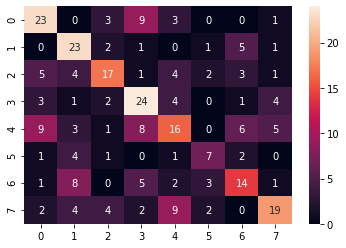

In [19]:
accuracy=accuracy_score(y_test, y_pred)
#Print the accuracy
print("Accuracy: {:.2f}%".format(accuracy*100))
#Print the report
print("Statistics:")
print(classification_report(y_test,y_pred))

print("Confusion Matrix:")
matrix = confusion_matrix(y_test,y_pred)
df_matrix = pd.DataFrame(matrix)
sn.heatmap(df_matrix, annot=True, fmt='')
plt.show()

In [20]:
#calculate and display the train and test accuracy
train_accuracy = float(svclassifier.score(X_train, y_train)*100)
print("Train Accuracy: {:.2f}%".format(train_accuracy))
test_accuracy = float(svclassifier.score(X_test, y_test)*100)
print("Test Accuracy: {:.2f}%".format(test_accuracy))

Train Accuracy: 64.84%
Test Accuracy: 49.65%


## Cross-Validation
after calculating the training accuracy and comparing with testing accuracy, to check for overfitting of data.
5-fold cross validation of the dataset with the SVC classifier.

In [21]:
# no. of folds cv = 5
cv_results = cross_val_score(svclassifier, X, y, cv = 5)
print(cv_results)

[0.45833333 0.47916667 0.42708333 0.42708333 0.44791667]


## Scaling

When performing the linear SVM classification, it is often helpful to normalize the training data and scale the test data with the mean and standard deviation of training data.

In [22]:
#splitting dataset into train/ test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

In [23]:
# Setup the pipeline steps and create the pipeline and fit the pipeline to the training set: svc_scaled
steps = [('scaler', StandardScaler()),
        ('SVM', SVC())]
pipeline = Pipeline(steps)
svc_scaled = pipeline.fit(X_train, y_train)

In [24]:
# fit a classifier to the unscaled data, Compute and print metrics
svc_unscaled = SVC(kernel = 'linear').fit(X_train, y_train)
Scaling_accuracy = float(svc_scaled.score(X_test, y_test)*100)
Non_Scaling_accuracy = float(svc_unscaled.score(X_test, y_test)*100)
print('Accuracy with Scaling: {:.2f}%'.format(Scaling_accuracy))
print('Accuracy without Scaling: {:.2f}%'.format(Non_Scaling_accuracy))

Accuracy with Scaling: 54.86%
Accuracy without Scaling: 45.83%


## Generalization check
Checking for overfitting or underfitting by comparing the training and testing scores of the model

In [25]:
train_accuracy = float(svc_scaled.score(X_train, y_train)*100)
print("Train Accuracy: {:.2f}%".format(train_accuracy))
test_accuracy = float(svc_scaled.score(X_test, y_test)*100)
print("Test Accuracy: {:.2f}%".format(test_accuracy))

Train Accuracy: 78.12%
Test Accuracy: 54.86%


In [26]:
scaled_predictions = svc_scaled.predict(X_test)

Accuracy: 54.86%
Statistics:
              precision    recall  f1-score   support

       angry       0.81      0.67      0.73        33
        calm       0.55      0.79      0.65        42
     disgust       0.48      0.63      0.55        38
        fear       0.63      0.54      0.58        41
       happy       0.54      0.30      0.38        47
     neutral       0.00      0.00      0.00        22
         sad       0.36      0.57      0.44        30
    surprise       0.60      0.74      0.67        35

    accuracy                           0.55       288
   macro avg       0.50      0.53      0.50       288
weighted avg       0.53      0.55      0.52       288

Confusion Matrix:


C:\Users\User\anaconda3\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\anaconda3\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\anaconda3\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


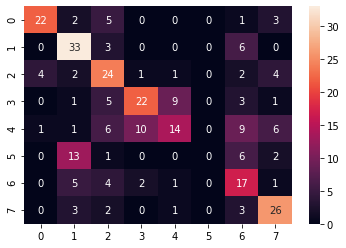

In [27]:
accuracy=accuracy_score(y_test, scaled_predictions)

#Print the accuracy
print("Accuracy: {:.2f}%".format(accuracy*100))

#Print the report
print("Statistics:")
print(classification_report(y_test,scaled_predictions))

print("Confusion Matrix:")
cm = confusion_matrix(y_test,scaled_predictions)
df_cm = pd.DataFrame(cm)
sn.heatmap(df_cm, annot=True, fmt='')
plt.show()

In [28]:
cv_results = cross_val_score(svc_scaled, X, y, cv = 5)
print(cv_results)

[0.54513889 0.56597222 0.55208333 0.54861111 0.52083333]
